In [1]:
from empirical_study.main_function import perform_empirical_study
from empirical_study.utils import *
from empirical_study.plot_functions import *
import yfinance as yf

For a given volatility index $v$ and a market index $S$, for a given `setting` which is a list of tuples `(n,j)` or `(n, (j_1,..., j_k))` , for each timestep $t$ (in days):
$$
r_t = \frac{S_t - S_{t-1}}{S_{t-1}}
$$
$$
R_{n,t} = \sum_{t_i \leq t} K_n(t-t_i)r_{t_i}^n
$$

Then the model estimates the volatility as
$$
v_t^p = \beta_0 + \sum_{n} \sum_{j\in\{j_1,\dots, j_k\}} \beta_{n,j} R_{n,t}^j
$$
Note: when there is only one $j$ associated to $n$, $\beta_{n,j}$ is simply noted $\beta_n$.


For example, the linear model we suggest is defined by `p=1`, `setting=[(1,1), (2,1/2)]`, resulting in
$$
v_t = \beta_0 + \beta_1 R_{1,t} + \beta_2 R_{2,t}^{1/2}
$$
The model (M3) is defined by `p=2`, `setting=[(1,(1,2))]`, resulting in
$$
v_t^2 = \beta_0 + \beta_{1,1} R_{1,t} + \beta_{1,2} R_{1,t}^2
$$

Note that there is one kernel per $n$. The kernels are either time-shifted power-laws or convex combinations of two exponentials.

In [2]:
load_from = pd.to_datetime('1995-01-01')  # Need at least 4 years prior to the first training day
train_start_date = pd.to_datetime('2000-01-01')
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2022-05-15')

In [3]:
# Load data on SPX and VIX
spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)
vix_data = yf.Ticker("^VIX").history(start=load_from, end=test_end_date)

In [4]:
spx_data.index = pd.to_datetime(spx_data.index.date)
vix_data.index = pd.to_datetime(vix_data.index.date)

In [5]:
spx = spx_data['Close']
vix = vix_data['Close'] / 100

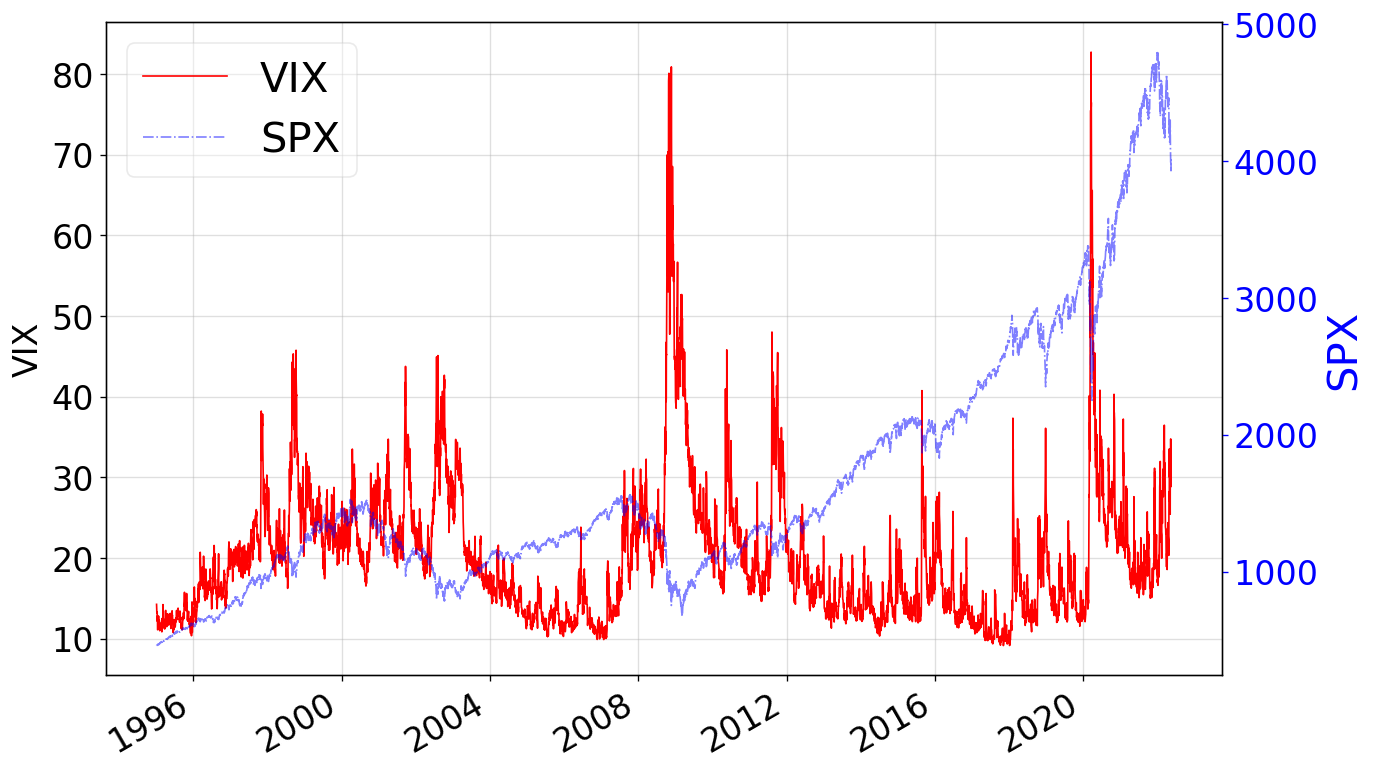

In [6]:
# Plot data
fig = plot_timeseries(100*vix, label='VIX', secondary=spx, secondary_label='SPX', 
                      add_hline=False, color_secondary='b', display_score=False)

In [7]:
max_delta = 1000  # Number of past returns used in the computation of R_{n,t} in business days
test_start = test_start_date
test_end = test_end_date
train_start = train_start_date
tspl = True # if True, use time-shifted power-law kernels. Otherwise, use a convex combination of two exponentials

In [8]:
# Next cell runs in about 1-3 minutes if tspl=True, and up to 10 minutes if tspl=False.
p = 1
setting = [(1, 1), (2, 1/2)] # Our linear model
# setting = [(1, (1,2)), (2, 1/2)] # Our model with a parabolic term in R_1
sol = perform_empirical_study(vol=vix, index=spx, p=p, tspl=tspl, setting=setting, train_start_date=train_start,
                                  test_start_date=test_start, test_end_date=test_end, 
                                  max_delta=max_delta)

In [9]:
# Computed optimal parameters
sol['opt_params']

{'beta_0': 0.057294554769727155,
 'beta_1': -0.09462027431340769,
 'beta_2': 0.8183669914871688,
 'alpha_1': 1.0562015431102165,
 'alpha_2': 1.5971775363990974,
 'delta_1': 0.020111644101787014,
 'delta_2': 0.051624749754368544}

In [10]:
# scores
print({key: sol[key] for key in ['train_r2', 'test_r2', 'train_rmse', 'test_rmse']})

{'train_r2': 0.9461198466634522, 'test_r2': 0.8553946646338623, 'train_rmse': 0.019999571218090643, 'test_rmse': 0.035183504344669}


In [11]:
# plot timeseries of predictions vs true
pred_on_test = sol['test_pred'] * 100
pred_on_train = sol['train_pred'] * 100
target_on_test = data_between_dates(vix, start_date=test_start_date, end_date=test_end_date) * 100 
target_on_train = data_between_dates(vix, start_date=train_start_date, end_date=test_start_date) * 100
index_on_test = data_between_dates(spx, start_date=test_start_date, end_date=test_end_date)
index_on_train = data_between_dates(spx, start_date=train_start_date, end_date=test_start_date)

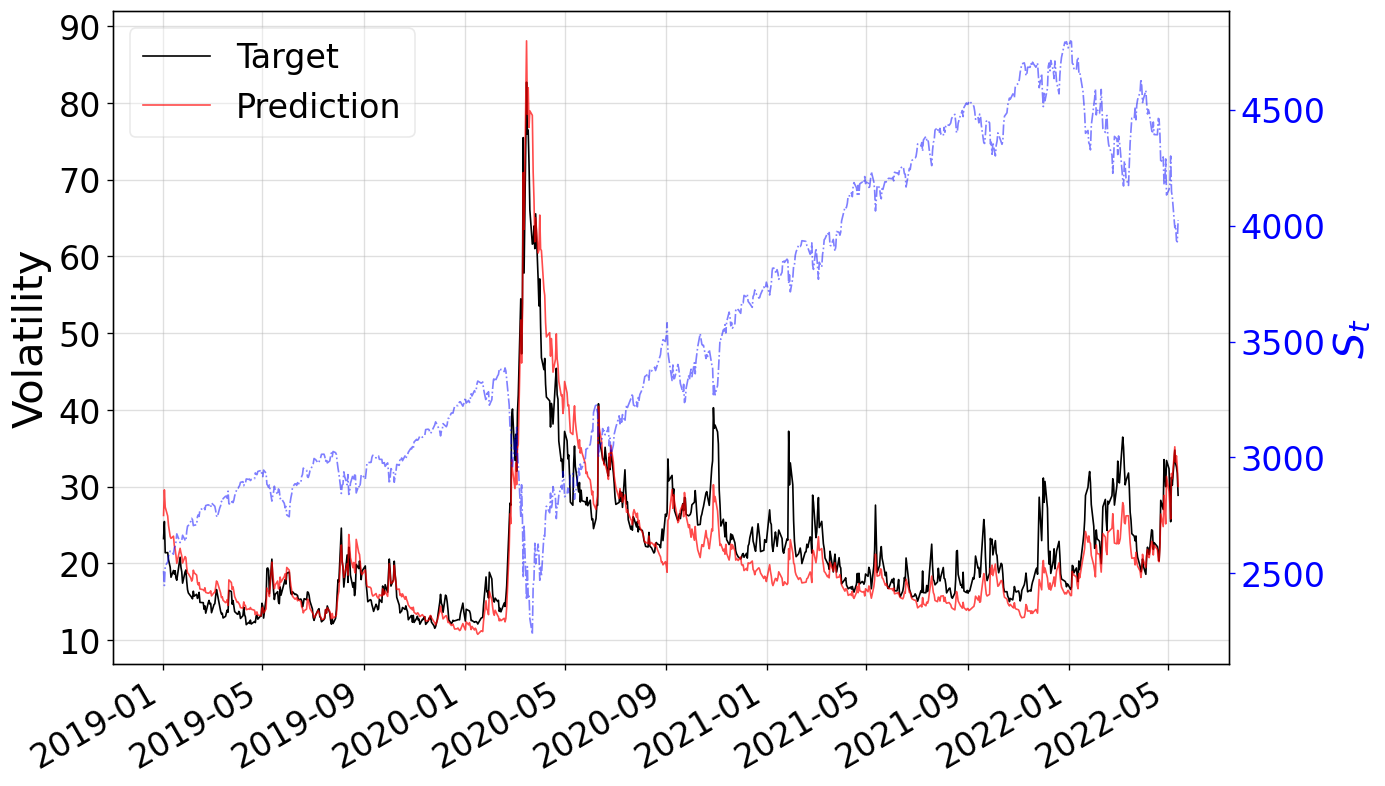

In [12]:
fig = plot_prediction_timeseries(y_target=target_on_test, y_pred=pred_on_test, index=index_on_test)

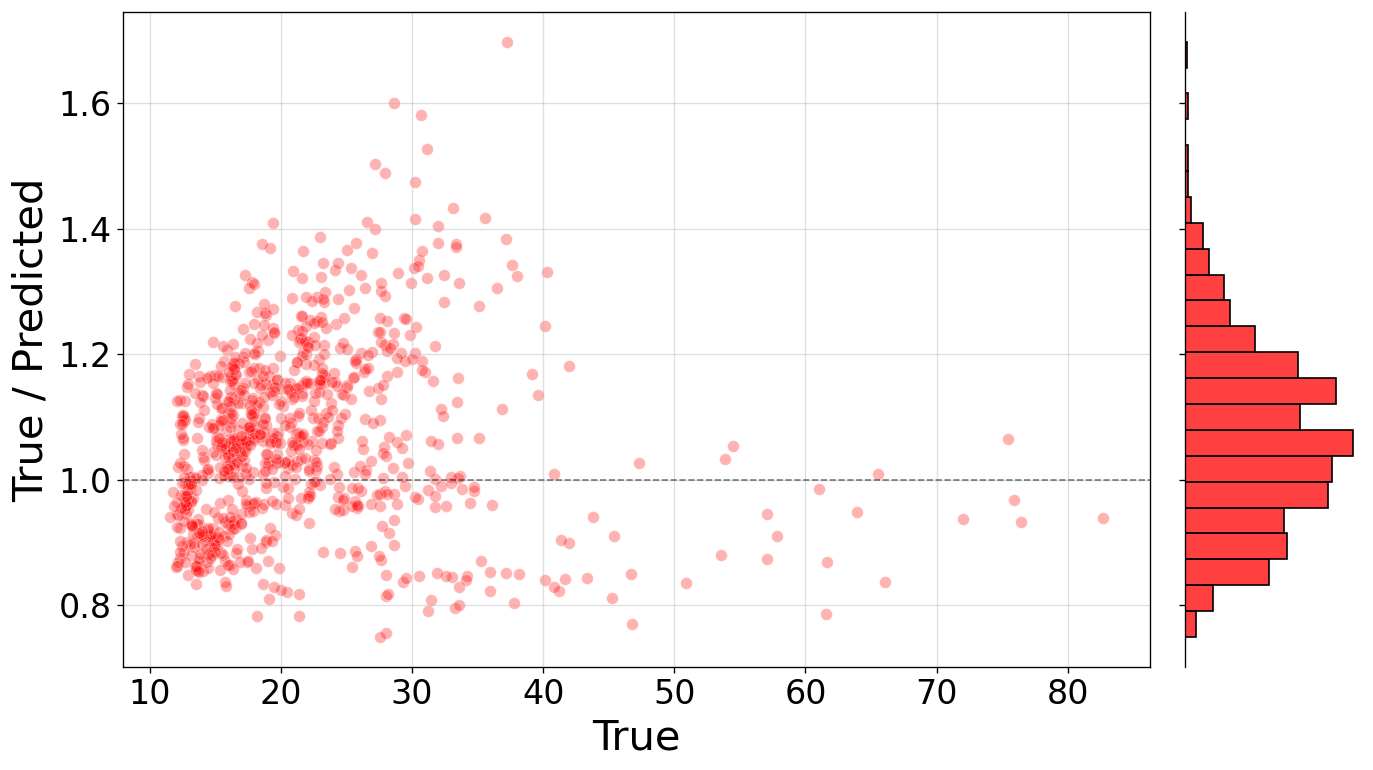

In [13]:
# Plot residuals on train set
fig = plot_prediction_vs_true(y_pred=pred_on_test, y_target=target_on_test, plot_residuals=True, ratio_residuals=True)

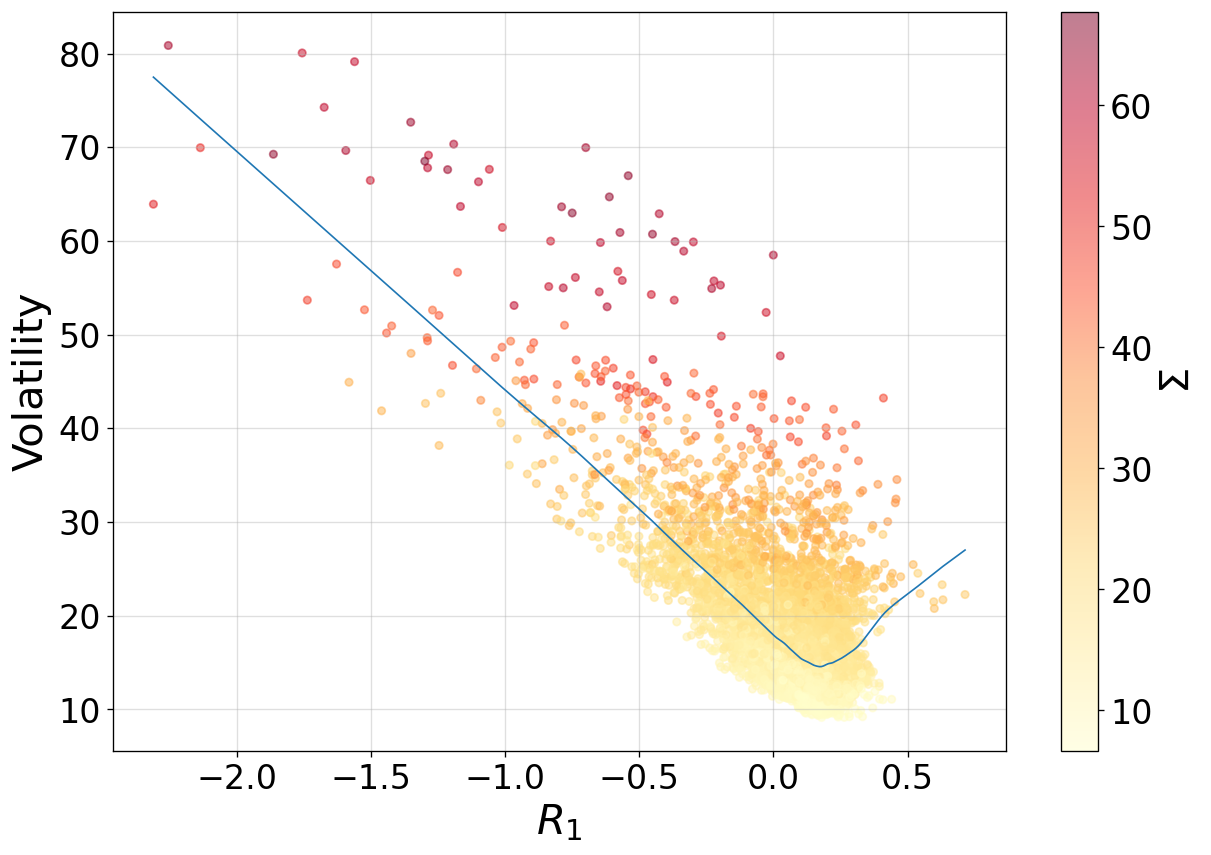

In [14]:
### Target vs Features
r_1_train = data_between_dates(sol['features']['R_1'], start_date=train_start_date, end_date=test_start_date)
sigma_train =  data_between_dates(sol['features']['R_2^0.5'], start_date=train_start_date, end_date=test_start_date) * 100
fig = plot_vol_against_feature(feature=r_1_train, target=target_on_train, color_variable=sigma_train, 
                               color_label='$\Sigma$', feature_name='$R_1$')

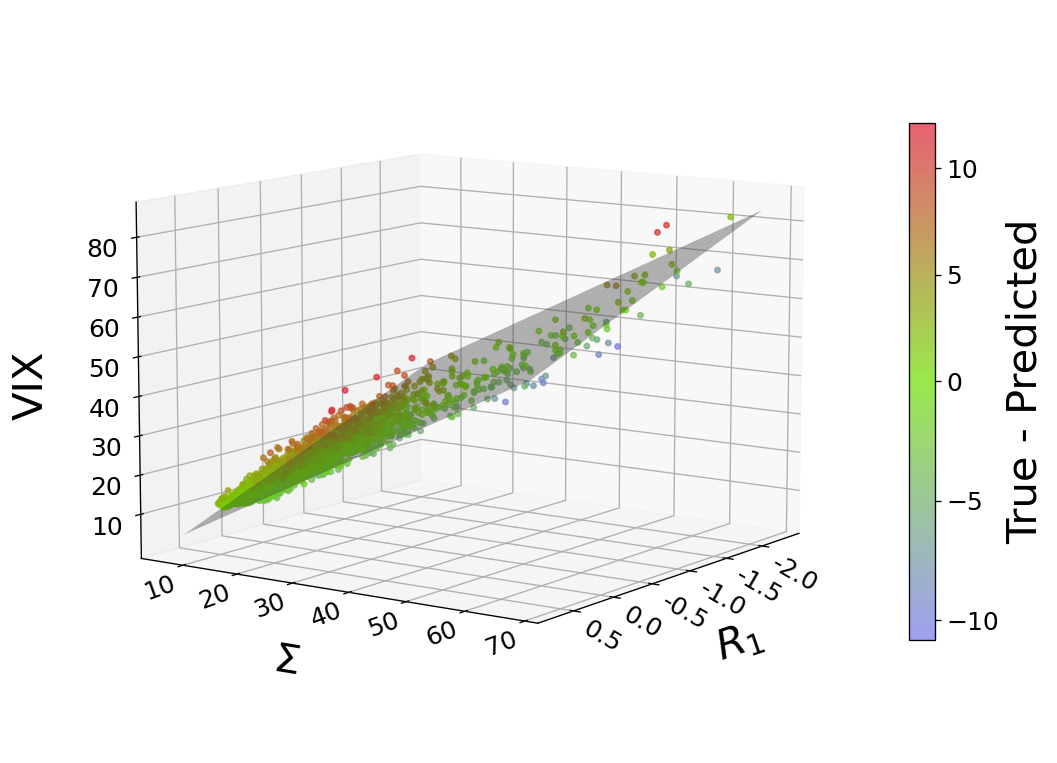

In [15]:
fig = plot_3d(r_1_train, sigma_train, target_on_train, xlabel='$R_1$', ylabel='$\Sigma$', zlabel='VIX', figsize=bigfigsize)